In [1]:
import numpy as np
from IPython.display import display

from notebooks.util.long_memory_utils import *
from liquidity.util.utils import compute_returns

from powerlaw_function.powerlaw_function import Fit

from hurst_exponent.hurst_exponent import standard_hurst, generalized_hurst
from hurst_exponent.util.utils import interpret_hurst, augmented_dickey_fuller

In [2]:
# Automatically reload changes in package dependencies
%load_ext autoreload
%autoreload 2

In [3]:
# Number of events to use
EVENTS_RANGE = 500000

# Lag/window size for Hurst and the ACF
LAG = 1000

## Load market orders raw sample data

In [4]:
# Load raw sample data  from CSV
stocks = ['TSLA', 'AMZN', 'NFLX', 'MSFT', 'EBAY', 'APPL']

current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'market_orders')
acf_data_dir = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'long_memory')

stock_dfs = {}

# Loop through each stock
for stock in stocks:

    filename = f"{stock}-2016-R1.csv"

    stock_file_path = os.path.join(data_dir, filename)

    # Read the CSV and store in the dictionary
    stock_dfs[stock] = pd.read_csv(stock_file_path)

# Access the dataframe using stock's ticker as key
tsla_raw_df = stock_dfs['TSLA']
amzn_raw_df = stock_dfs['AMZN']
nflx_raw_df = stock_dfs['NFLX']
msft_raw_df = stock_dfs['MSFT']
ebay_raw_df = stock_dfs['EBAY']
appl_raw_df = stock_dfs['APPL']

## 1. Returns

In [5]:
# Compute returns
tsla_returns = compute_returns(tsla_raw_df)['returns']
msft_returns = compute_returns(msft_raw_df)['returns']
amzn_returns = compute_returns(amzn_raw_df)['returns']
nflx_returns = compute_returns(nflx_raw_df)['returns']
ebay_returns = compute_returns(ebay_raw_df)['returns']
appl_returns = compute_returns(appl_raw_df)['returns']

returns = {
  'TSLA': tsla_returns,
  'MSFT': msft_returns,
  'AMZN': amzn_returns,
  'NFLX': nflx_returns,
  'EBAY': ebay_returns,
  'APPL': appl_returns
}
returns = {stock: data.head(EVENTS_RANGE) for stock, data in returns.items()}

In [6]:
# Compute ACF for TSLA using the linear method
tsla_acf = compute_acf("TSLA", tsla_returns, option="linear")
display(tsla_acf)

('TSLA',
 0       1.000000
 1      -0.015541
 2       0.001610
 3       0.005973
 4       0.005574
           ...   
 996    -0.001168
 997     0.000533
 998     0.001713
 999    -0.000517
 1000   -0.000748
 Length: 1001, dtype: float64)

### 1.1. Stationarity Test

To test whether our time series are stationary, we perform an augmented Dickey-Fuller test on each series, which uses the following null and alternative hypotheses:

- **H0:** The time series is non-stationary.
  - In other words, it has some time-dependent structure and does not have constant variance over time.
  - There is at least one unit root.

- **H1:** The time series is stationary.

- **Note:** If the p-value from the test is less than some significance level (e.g. $\alpha$ = .05), then we can reject the null hypothesis and conclude that the time series is stationary.

In [7]:
# ADF test
for stock, data in returns.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -313.78
p-value: 0.00,
N: 499995, 
critical values: {'1%': -3.430363078797933, '5%': -2.8615457806747435, '10%': -2.5667730768420047}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -351.00
p-value: 0.00,
N: 499996, 
critical values: {'1%': -3.430363078771775, '5%': -2.861545780663182, '10%': -2.566773076835851}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -313.79
p-value: 0.00,
N: 499995, 
critical values: {'1%': -3.430363078797933, '5%': -2.8615457806747435, '10%': -2.5667730768420047}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -284.58
p-value: 0.00,
N: 499994, 
critical values: {'1%': -3.430363078824091, '5%': -2.861545780686305, '10%': -2.5667730768481585}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.



### 1.2. Return Autocorrelation Functions (ACFs)

There appears to be a clear difference between linear and nonlinear ACFs. If our data doesn’t contain significant non-linear patterns, both Pearson and Kendall methods could end up providing similar results.

**Key Points:**
- The **Kendall correlation** would detect non-linear relationships if they exist.
- If no non-linear relationships exist, it would just mirror the results of the Pearson correlation.
- Given this behavior, it’s best to use **Kendall** in case a non-linear relation holds for some data in our sample.


In [8]:
# Save data for lazy loading
linear_filename = f"{acf_data_dir}/mo_returns_linear_acfs.pkl"

# Linear ACF
linear_acfs = compute_acfs(filename=linear_filename, data=returns, option='linear')
print(linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


In [9]:
nonlinear_filename = f"{acf_data_dir}/mo_returns_nonlinear_acfs.pkl"

# Nonlinear ACF
nonlinear_acfs = compute_acfs(filename=nonlinear_filename, data=returns, option='nonlinear')
print(nonlinear_acfs.keys())

/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multipl

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


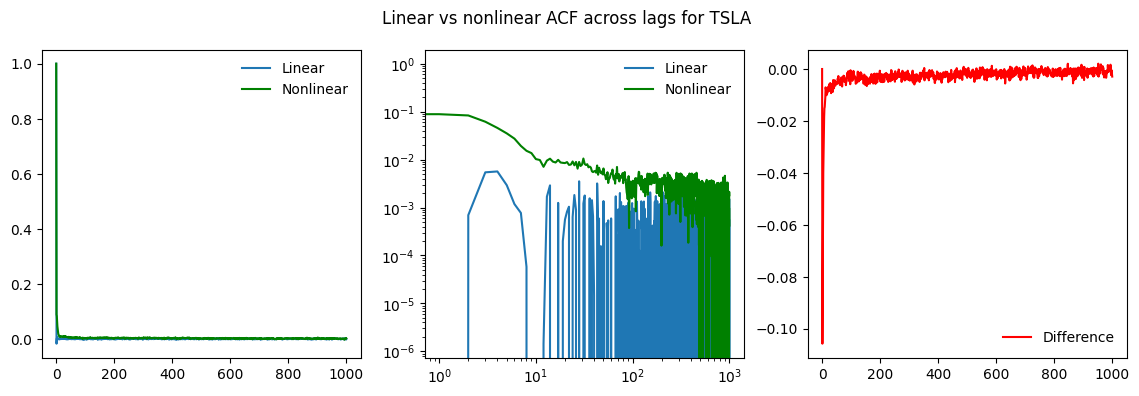

TSLA Max difference: 0.0020525645669067687


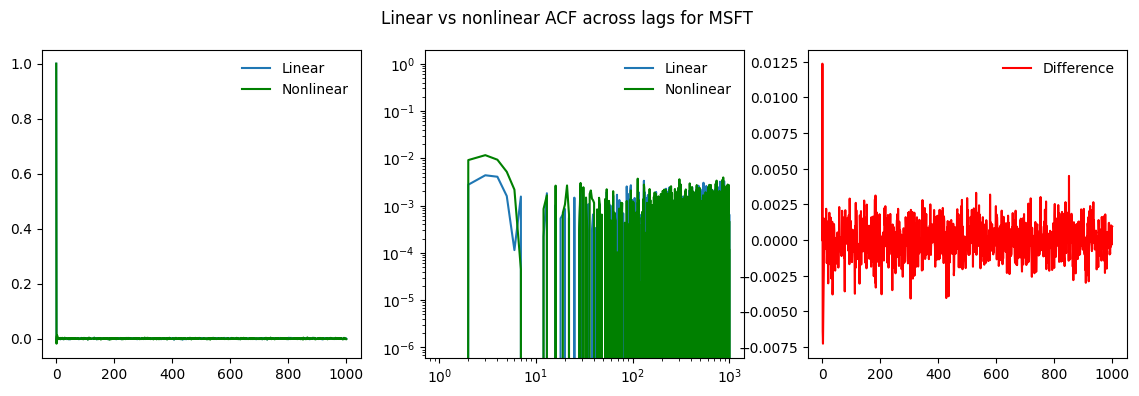

MSFT Max difference: 0.012371387089952274


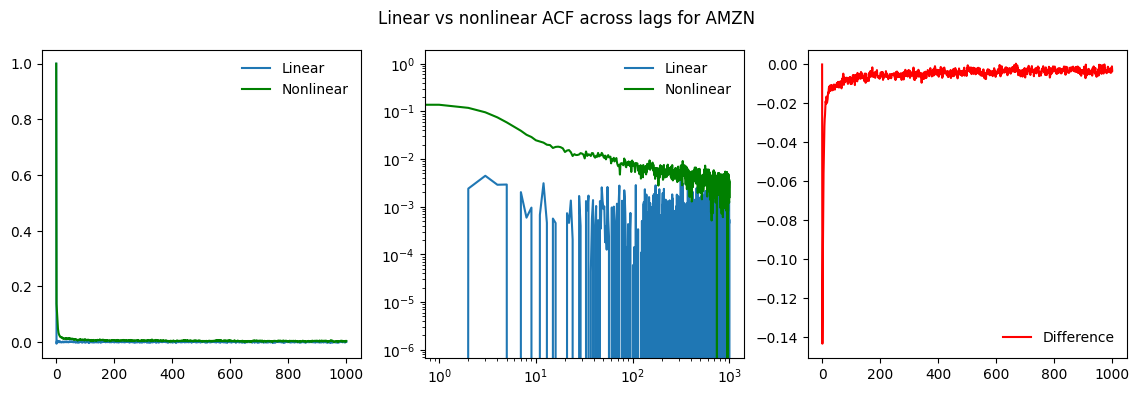

AMZN Max difference: 0.00040565617048145004


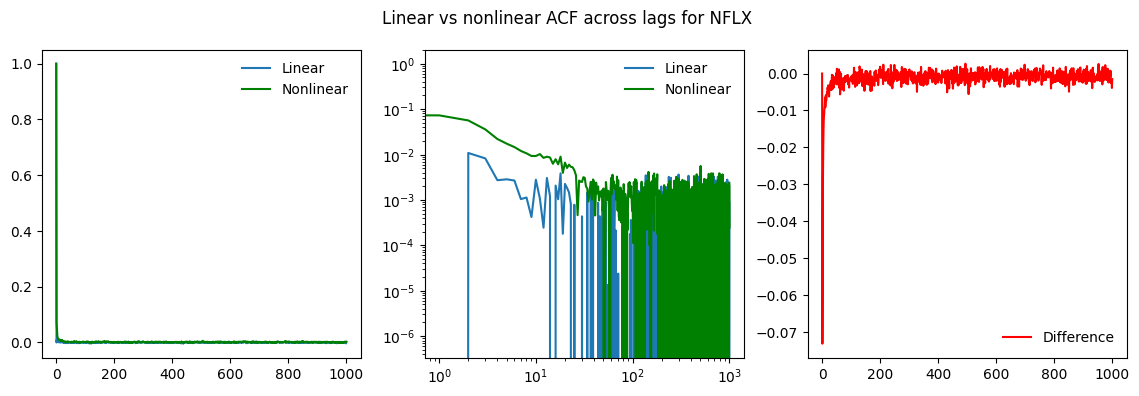

NFLX Max difference: 0.0026637602999851993


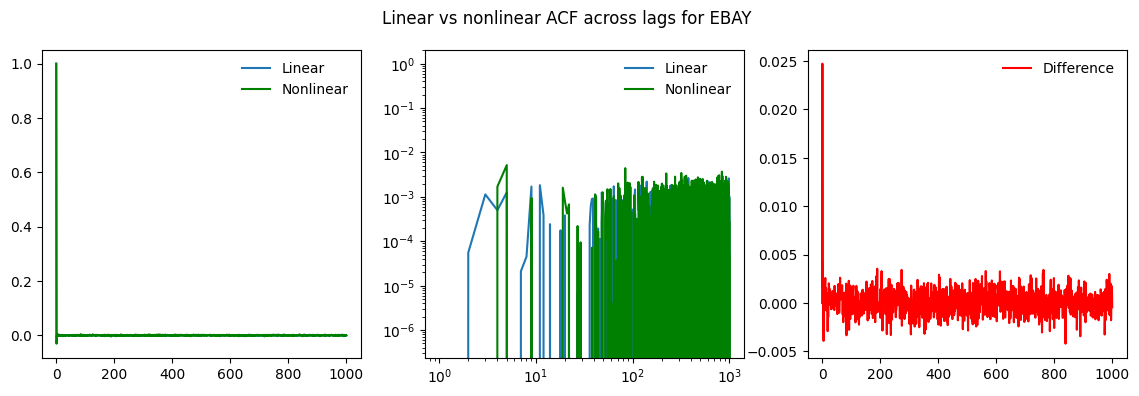

EBAY Max difference: 0.024722244623304974


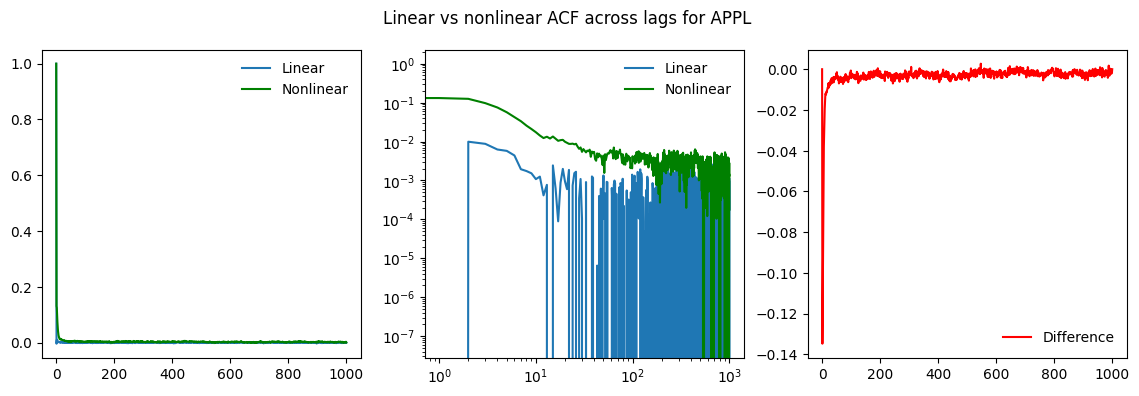

APPL Max difference: 0.002725687793802604


In [10]:
# Plot differences
# plot_acf_difference("TSLA", linear_acfs, nonlinear_acfs)
for stock_name in linear_acfs.keys():
    plot_acf_difference(stock_name, linear_acfs, nonlinear_acfs)

### 1.3. The Long Memory of Returns?

To determine if a random process exhibits long memory, we take the following approach:

1. **Infer an Autocorrelation Function (ACF):** Start by inferring the ACF from a finite return sample.

2. **Fit a Power-law to the ACF:** Use the inferred ACF to fit a power-law.

3. **Estimate Hurst Exponent:** Use standard and generalized hurst on cumulative sum of raw series.

#### 1.3.1. Estimate ACF scaling parameter

In [11]:
# TSLA Example
tsla_returns_acf = nonlinear_acfs['TSLA']
x = list(range(1, len(tsla_returns_acf) + 1))
xy_df = pd.DataFrame({"x_values": x, "y_values": tsla_returns_acf})

tsla_acf_fit = Fit(xy_df)
tsla_acf_fit.powerlaw.fit_results()


For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 5
xmin: 6.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 0.05295177803068753
alpha = -0.5462261052606372

Goodness of fit to data;
D = 0.2620481927710843
bic = -13190.55041357543
mape = 215.04084933768883
Adjusted R-squared = 0.6807407993561667




#### 1.3.2. For all assets

In [12]:
# Load the pre-computed ACFs
return_acf_values = {}

for stock, data in nonlinear_acfs.items():
    return_acf_values[stock] = construct_xy(data, stock)

In [13]:
# Using return_acf_values
fit_results_list = []
fit_objects = {}  # Dictionary to store fit objects

for stock, data in return_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data, xmin_index=10)
    if fit_dict:
        fit_results_list.append(fit_dict)
        fit_objects[stock] = fit_obj  # Store the fit object

acf_fit_results = pd.DataFrame(fit_results_list)
display(acf_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0529517...",5,6.0,0.262048,-13190.550414,215.040849,0.680741,-0.546226,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': -1255.689...",384,385.0,0.479741,-8267.830671,115.625421,-0.002582,-2.637842,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0726707...",7,8.0,0.156942,-13246.880606,30.848436,0.844161,-0.475235,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0427794...",6,7.0,0.283417,-13390.089366,399.928924,0.379634,-0.689841,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': -220.3004...",23,24.0,0.475460,-13049.916396,103.263270,0.005661,-3.646359,EBAY


In [14]:
fit_objects.keys()

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])

In [15]:
avg_gamma = acf_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_gamma}")

Average Gamma: -1.4100871320745636


In [16]:
# Retrieve the fit object for 'STOCK':
# tsla_acf_fit = fit_objects['AMZN']
# tsla_acf_fit.powerlaw.plot_fit()

### 1.4. Estimate Hurst Exponent

The Hurst Exponent, denoted by $H$, is a statistical measure of a time series which can be used to determine the nature of the series. Its value can range between 0 and 1:

- $H = 0.5$: The series is a random walk (Brownian motion). The future values do not depend on the past values.

- $H < 0.5$: The series has a tendency to revert to a mean, indicating negative autocorrelation. This is typical of "mean-reverting" series.

- $H > 0.5$: The series shows a trending behavior, meaning that increases (decreases) in the past will likely be followed by increases (decreases) in the future.

In [17]:
# TSLA Example
tsla_returns = compute_returns(tsla_raw_df)['returns'].cumsum()

# Estimate Hurst Exponent using both Standard and Generalized metod
hurst_std, fit_std = standard_hurst(tsla_returns)
hurst_gen, fit_gen = generalized_hurst(tsla_returns)

fit_std.powerlaw.fit_results()
fit_gen.powerlaw.fit_results()

print(f"Standard Hurst Exponent: {hurst_std} ({interpret_hurst(hurst_std)})")
print(f"Generalized Hurst Exponent: {hurst_gen} ({interpret_hurst(hurst_gen)})")


For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 1
xmin: 1.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 0.08878075715410834
alpha = 0.508993923594669

Goodness of fit to data;
D = 0.019562715765247412
bic = -10551.073137659814
mape = 0.3039840628666917
Adjusted R-squared = 0.9998873360358319



For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 28
xmin: 4.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 0.03435193222180402
alpha = 0.5866272248116898

Goodness of fit to data;
D = 0.010688836104513063
bic = -12636.526927697314
mape = 0.1914300187159466
Adjusted R-squared = 0.9999787658903939


Standard Hurst Exponent: 0.508993923594669 (Super-diffusive: series demonstrates persistent long-range dependence)
Generalized Hurst Exponent: 0.5866272248116898 (Super-diffusive: series demonstrates persistent long-range dependence)


#### 1.4.1 For all assets

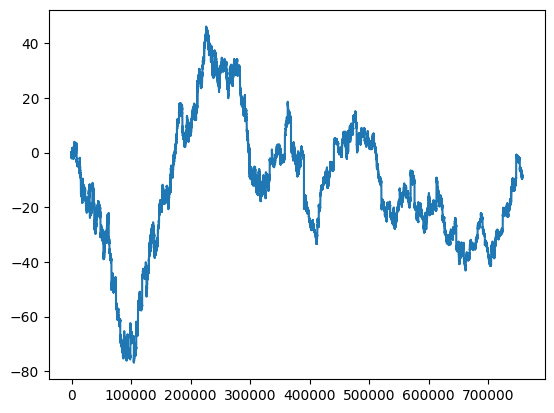

In [95]:
# Compute cumsum of returns as input for Hurst
tsla_cum_returns = compute_returns(tsla_raw_df)['returns']
amzn_cum_returns = compute_returns(msft_raw_df)['returns']
nflx_cum_returns = compute_returns(amzn_raw_df)['returns']
msft_cum_returns = compute_returns(nflx_raw_df)['returns']
ebay_cum_returns = compute_returns(ebay_raw_df)['returns']
appl_cum_returns = compute_returns(appl_raw_df)['returns']

cumsum_returns = {
  'TSLA': tsla_cum_returns.cumsum(),
  'MSFT': amzn_cum_returns.cumsum(),
  'AMZN': nflx_cum_returns.cumsum(),
  'NFLX': msft_cum_returns.cumsum(),
  'EBAY': ebay_cum_returns.cumsum(),
  'APPL': appl_cum_returns.cumsum()
}
# Update the dictionary to only keep the first EVENTS_RANGE items
cumsum_returns = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_returns.items()}
tsla_cumsum_returns = tsla_cum_returns = compute_returns(tsla_raw_df)['returns'].cumsum()
x = list(range(1, len(tsla_cum_returns)+1))
plt.plot(x, tsla_cum_returns)
plt.grid(False)
plt.show()

#### Standard Hurst

In [19]:
# Standard Hurst
method = 'standard'
fit_results_list = []
fit_objects = {}

for stock, data in cumsum_returns.items():
    fit_dict, fit = compute_hurst_exponent('returns', stock, data, method=method, max_lag=LAG)
    if fit_dict:
        fit_results_list.append(fit_dict)
        fit_objects[(stock, method, 'returns')] = fit

std_hurst_fit_results = pd.DataFrame(fit_results_list)
display(std_hurst_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0966371...",1,1.0,0.019830,-8155.271801,0.353587,0.999826,0.507449,TSLA,returns
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0103544...",1,1.0,0.021246,-11541.705829,0.364670,0.999860,0.496699,MSFT,returns
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1992195...",1,1.0,0.021246,-7644.877200,0.245626,0.999915,0.506514,AMZN,returns
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0353718...",1,1.0,0.021246,-9283.485707,0.510487,0.999732,0.505091,NFLX,returns
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0122494...",1,1.0,0.011331,-11931.106084,0.193559,0.999943,0.498017,EBAY,returns


In [20]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.5038186741102519


In [21]:
print(fit_objects.keys())

dict_keys([('TSLA', 'standard', 'returns'), ('MSFT', 'standard', 'returns'), ('AMZN', 'standard', 'returns'), ('NFLX', 'standard', 'returns'), ('EBAY', 'standard', 'returns'), ('APPL', 'standard', 'returns')])


In [22]:
# Retrieve standard Hurst fit object for specific 'STOCK'
# tsla_standard_fit = fit_objects[('TSLA', 'standard', 'returns')]
# tsla_standard_fit.powerlaw.plot_fit()

#### Generalized Hurst

In [23]:
# Generalized Hurst
method = 'generalized'
fit_results_list = []
fit_objects = {}

for stock, data in cumsum_returns.items():
    fit_dict, fit = compute_hurst_exponent('returns', stock, data, method=method,  max_lag=LAG)
    if fit_dict:
        fit_results_list.append(fit_dict)
        fit_objects[(stock, method, 'returns')] = fit

gen_hurst_fit_results = pd.DataFrame(fit_results_list)
display(gen_hurst_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0375192...",16,3.0,0.011577,-9919.975593,0.260907,0.999967,0.586810,TSLA,returns
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0043175...",37,6.0,0.011940,-14079.671972,0.077691,0.999995,0.552866,MSFT,returns
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0683325...",44,7.0,0.012066,-9051.808858,0.176826,0.999975,0.578240,AMZN,returns
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0165638...",9,2.0,0.011461,-10441.293990,0.579646,0.999871,0.550603,NFLX,returns
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0036646...",9,2.0,0.011461,-12913.242735,0.318575,0.999945,0.582212,EBAY,returns


In [24]:
# Generalized Hurst statistic across stocks
min_hurst_gen = gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.550603021008973
Max Generalized Hurst: 0.5868096083640313
Average Generalized Hurst: 0.5711338261591664
Standard_dev Generalized Hurst: 0.015482613435676987


In [25]:
print(fit_objects.keys())

dict_keys([('TSLA', 'generalized', 'returns'), ('MSFT', 'generalized', 'returns'), ('AMZN', 'generalized', 'returns'), ('NFLX', 'generalized', 'returns'), ('EBAY', 'generalized', 'returns'), ('APPL', 'generalized', 'returns')])


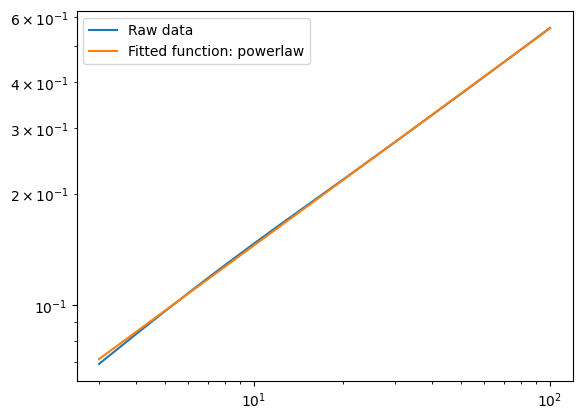

In [26]:
# Retrieve generalized fit object for specific 'STOCK'
tsla_generalized_fit = fit_objects[('TSLA', 'generalized', 'returns')]
tsla_generalized_fit.powerlaw.plot_fit()

## 2. Percentage Returns

In [27]:
# Compute percentage returns
tsla_percentage_returns = compute_returns(tsla_raw_df)['pct_returns']
msft_percentage_returns = compute_returns(msft_raw_df)['pct_returns']
amzn_percentage_returns = compute_returns(amzn_raw_df)['pct_returns']
nflx_percentage_returns = compute_returns(nflx_raw_df)['pct_returns']
ebay_percentage_returns = compute_returns(ebay_raw_df)['pct_returns']
appl_percentage_returns = compute_returns(appl_raw_df)['pct_returns']

percentage_returns = {
  'TSLA': tsla_percentage_returns,
  'MSFT': msft_percentage_returns,
  'AMZN': amzn_percentage_returns,
  'NFLX': nflx_percentage_returns,
  'EBAY': ebay_percentage_returns,
  'APPL': appl_percentage_returns
}
# Update the dictionary to only keep the first EVENTS_RANGE items
percentage_returns = {stock: data.head(EVENTS_RANGE) for stock, data in percentage_returns.items()}

### Stationarity Test

In [28]:
# ADF test
for stock, data in percentage_returns.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -313.55
p-value: 0.00,
N: 499995, 
critical values: {'1%': -3.430363078797933, '5%': -2.8615457806747435, '10%': -2.5667730768420047}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -351.01
p-value: 0.00,
N: 499996, 
critical values: {'1%': -3.430363078771775, '5%': -2.861545780663182, '10%': -2.566773076835851}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -313.59
p-value: 0.00,
N: 499995, 
critical values: {'1%': -3.430363078797933, '5%': -2.8615457806747435, '10%': -2.5667730768420047}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -284.80
p-value: 0.00,
N: 499994, 
critical values: {'1%': -3.430363078824091, '5%': -2.861545780686305, '10%': -2.5667730768481585}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.



### 2.1. Percentage returns ACF

In [29]:
# Linear ACF
percentage_returns_linear_acf_filename = f"{acf_data_dir}/mo_percentage_returns_linear_acfs.pkl"
percentage_returns_linear_acfs = compute_acfs(filename=percentage_returns_linear_acf_filename, data=percentage_returns, option='linear')
print(percentage_returns_linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


In [30]:
# Nonlinear ACF
percentage_returns_nonlinear_acf_filename = f"{acf_data_dir}/mo_percentage_returns_nonlinear_acfs.pkl"
percentage_returns_nonlinear_acfs = compute_acfs(filename=percentage_returns_nonlinear_acf_filename, data=percentage_returns, option='nonlinear')
print(percentage_returns_nonlinear_acfs.keys())

/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multipl

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


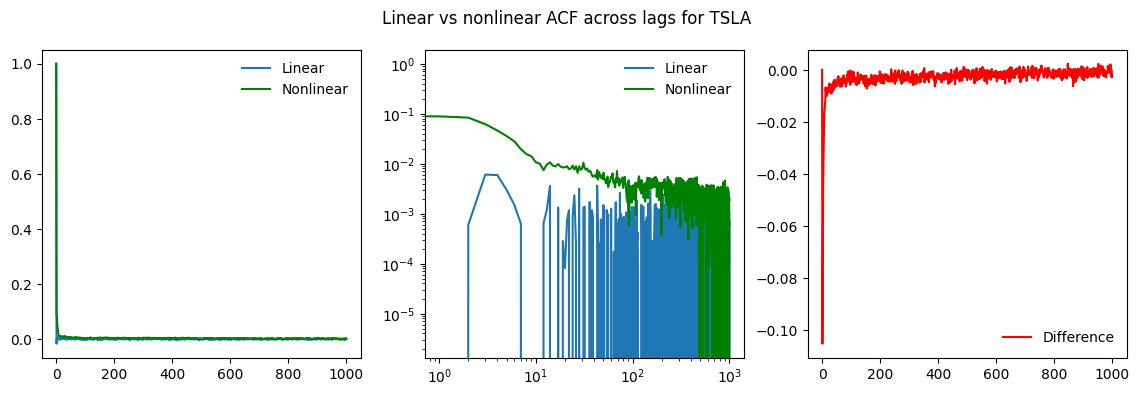

TSLA Max difference: 0.002319443130534824


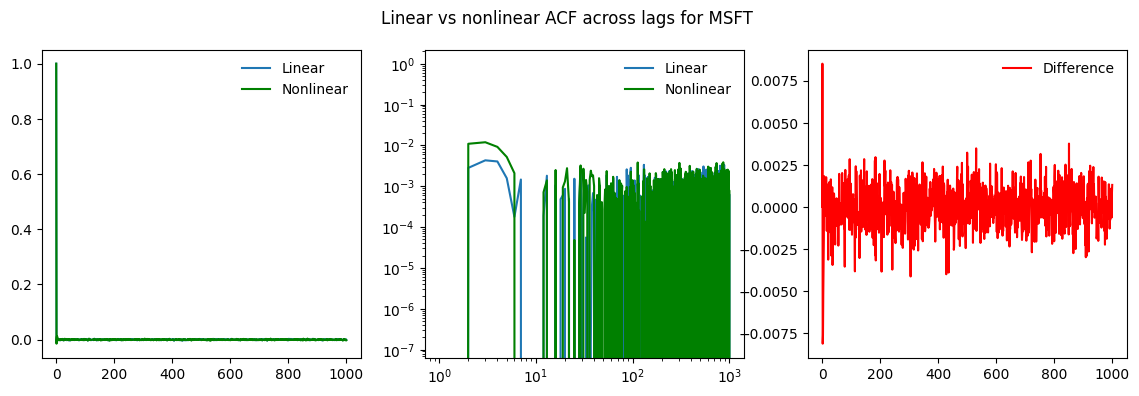

MSFT Max difference: 0.008507006327508376


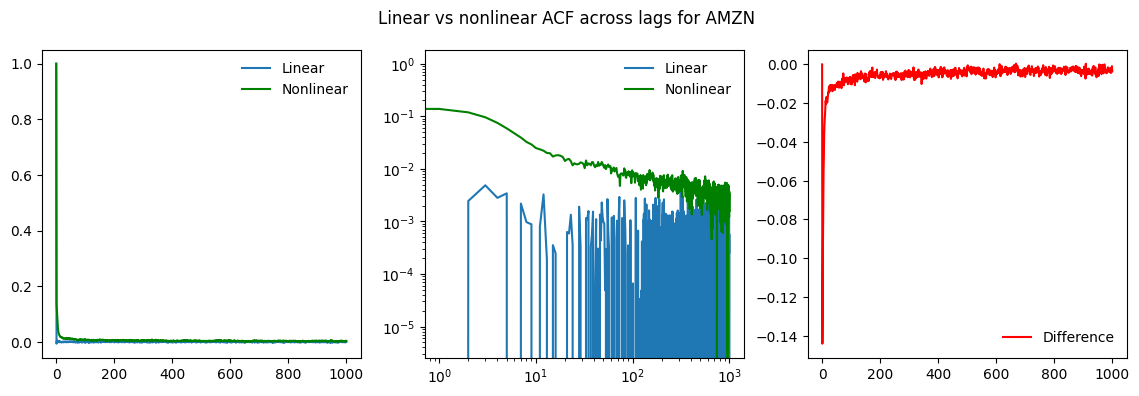

AMZN Max difference: 0.00037628326661415636


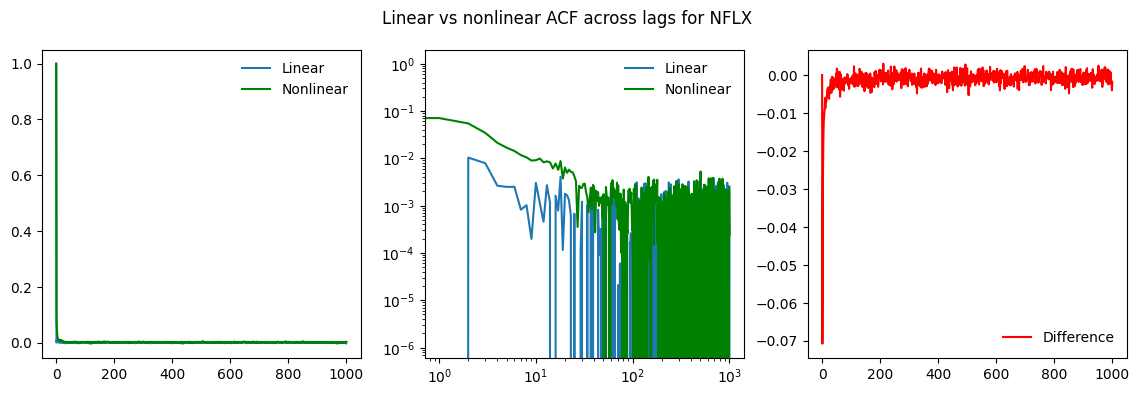

NFLX Max difference: 0.0029888530981321587


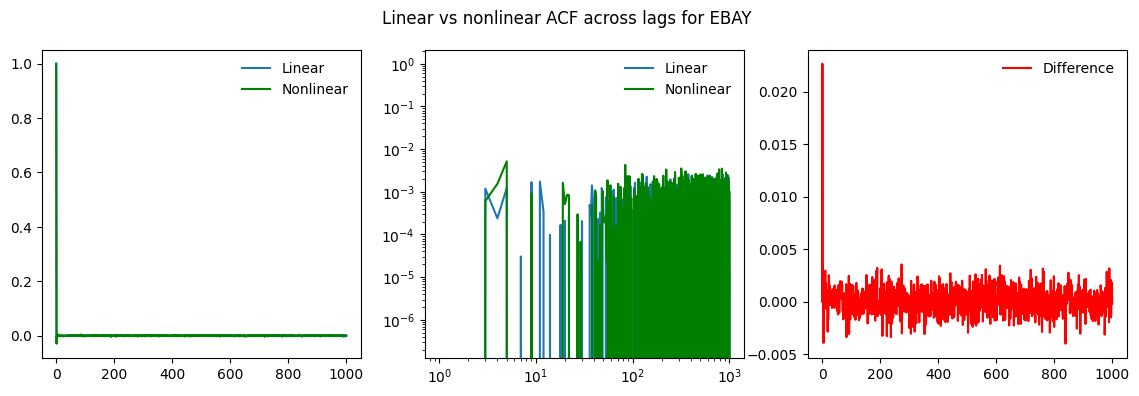

EBAY Max difference: 0.0226631155145329


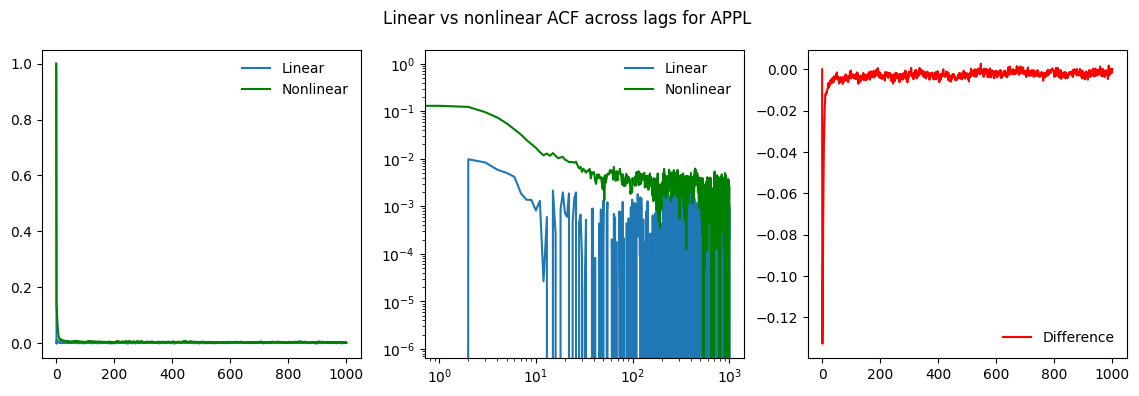

APPL Max difference: 0.0027384979190530996


In [31]:
for stock_name in percentage_returns_linear_acfs.keys():
    plot_acf_difference(stock_name, percentage_returns_linear_acfs, percentage_returns_nonlinear_acfs)

### 2.2. Fit power law to percentage returns ACF

In [32]:
# Load the pre-computed ACFs
percentage_returns_acf_values = {}

for stock, data in percentage_returns_nonlinear_acfs.items():
    percentage_returns_acf_values[stock] = construct_xy(data, stock)

In [33]:
# Using percentage_return_acf_values
percentage_returns_fit_list = []
percentage_returns_fit_objects = {}

for stock, data in percentage_returns_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data, xmin_index=10)
    if fit_dict:
        percentage_returns_fit_list.append(fit_dict)
        percentage_returns_fit_objects[stock] = fit_obj  # Store the fit object

percentage_returns_fit_results = pd.DataFrame(percentage_returns_fit_list)
display(percentage_returns_fit_results.head())

cannot unpack non-iterable NoneType object


,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0525728...",5,6.0,0.254016,-13196.095484,162.293535,0.684985,-0.539789,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': -302.4185...",354,355.0,0.482226,-8665.413402,107.050541,-0.003209,-2.452766,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0729695...",7,8.0,0.158954,-13246.442130,31.503245,0.845703,-0.475024,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0438037...",6,7.0,0.285427,-13431.183297,281.508142,0.375746,-0.708825,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': -252.3304...",592,593.0,0.481663,-5512.103363,127.279961,-0.003223,-2.218565,EBAY


In [34]:
percentage_returns_fit_objects.keys()

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])

In [35]:
avg_alpha = percentage_returns_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

Average Gamma: -1.1504877109880935


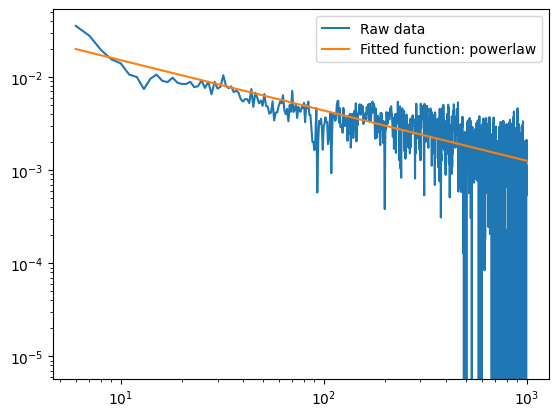

In [36]:
tsla_acf_fit = percentage_returns_fit_objects['TSLA']
tsla_acf_fit.powerlaw.plot_fit()

### 2.3 Percentage returns Hurst Exponents

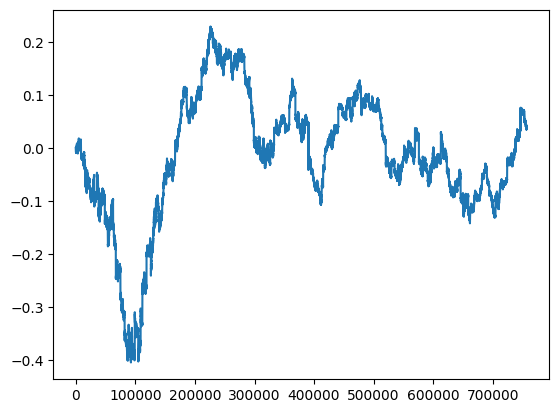

In [37]:
# Compute cumsum of percentage returns
cumsum_percentage_returns = {
  'TSLA': tsla_percentage_returns.cumsum(),
  'MSFT': msft_percentage_returns.cumsum(),
  'AMZN': amzn_percentage_returns.cumsum(),
  'NFLX': nflx_percentage_returns.cumsum(),
  'EBAY': ebay_percentage_returns.cumsum(),
  'APPL': appl_percentage_returns.cumsum()
}
# Update the dictionary to only keep the first EVENTS_RANGE items
cumsum_percentage_returns = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_percentage_returns.items()}
tsla_cumsum_percentage_returns = tsla_percentage_returns.cumsum()
x = list(range(1, len(tsla_cumsum_percentage_returns)+1))
plt.plot(x, tsla_cumsum_percentage_returns)
plt.grid(False)
plt.show()

#### Standard Hurst

In [38]:
# Standard Hurst
method = 'standard'
percentage_returns_fit_results_list = []
percentage_returns_fit_objects = {}

for stock, data in cumsum_percentage_returns.items():
    fit_dict, fit = compute_hurst_exponent('percentage_returns', stock, data, method=method, max_lag=LAG)
    if fit_dict:
        percentage_returns_fit_results_list.append(fit_dict)
        percentage_returns_fit_objects[(stock, method, 'percentage_returns')] = fit

percentage_returns_std_hurst_fit_results = pd.DataFrame(percentage_returns_fit_results_list)
display(percentage_returns_std_hurst_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0004849...",1,1.0,0.019830,-15461.643623,0.399202,0.999780,0.508013,TSLA,percentage_returns
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0002004...",1,1.0,0.021246,-17129.299610,0.356580,0.999864,0.496778,MSFT,percentage_returns
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0003401...",1,1.0,0.021246,-16487.873002,0.250014,0.999893,0.505628,AMZN,percentage_returns
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0003641...",1,1.0,0.021246,-15805.669621,0.502321,0.999751,0.503724,NFLX,percentage_returns
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0004586...",1,1.0,0.011331,-16534.265982,0.185961,0.999940,0.497643,EBAY,percentage_returns


In [39]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = percentage_returns_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.5031890346467323


In [40]:
display(percentage_returns_fit_objects.keys())

dict_keys([('TSLA', 'standard', 'percentage_returns'), ('MSFT', 'standard', 'percentage_returns'), ('AMZN', 'standard', 'percentage_returns'), ('NFLX', 'standard', 'percentage_returns'), ('EBAY', 'standard', 'percentage_returns'), ('APPL', 'standard', 'percentage_returns')])

#### Generalized Hurst

In [41]:
# Generalized Hurst
method = 'generalized'
percentage_returns_fit_results_list = []
percentage_returns_fit_objects = {}

for stock, data in cumsum_percentage_returns.items():
    fit_dict, fit = compute_hurst_exponent('percentage_returns', stock, data, method=method, max_lag=LAG)
    if fit_dict:
        percentage_returns_fit_results_list.append(fit_dict)
        percentage_returns_fit_objects[(stock, method, 'percentage_returns')] = fit

percentage_returns_gen_hurst_fit_results = pd.DataFrame(percentage_returns_fit_results_list)
display(percentage_returns_gen_hurst_fit_results.head(10))

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001798...",9,2.0,0.011461,-17323.958083,0.323904,0.999962,0.588096,TSLA,percentage_returns
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 8.3599837...",37,6.0,0.011940,-19368.864495,0.077867,0.999995,0.552956,MSFT,percentage_returns
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001154...",37,6.0,0.011940,-17645.468864,0.193550,0.999973,0.577621,AMZN,percentage_returns
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001689...",1,1.0,0.011331,-16865.263188,0.783703,0.999845,0.550583,NFLX,percentage_returns
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001396...",1,1.0,0.011331,-17578.113955,0.455990,0.999940,0.581454,EBAY,percentage_returns
5,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001027...",1,1.0,0.011331,-17087.783883,1.092390,0.999778,0.580648,APPL,percentage_returns


In [42]:
# Generalized Hurst statistic across stocks
min_hurst_gen = percentage_returns_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = percentage_returns_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = percentage_returns_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = percentage_returns_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.5505830913313716
Max Generalized Hurst: 0.5880962609787088
Average Generalized Hurst: 0.5718931097722811
Standard_dev Generalized Hurst: 0.015975872412061925


In [43]:
print(percentage_returns_fit_objects.keys())

dict_keys([('TSLA', 'generalized', 'percentage_returns'), ('MSFT', 'generalized', 'percentage_returns'), ('AMZN', 'generalized', 'percentage_returns'), ('NFLX', 'generalized', 'percentage_returns'), ('EBAY', 'generalized', 'percentage_returns'), ('APPL', 'generalized', 'percentage_returns')])


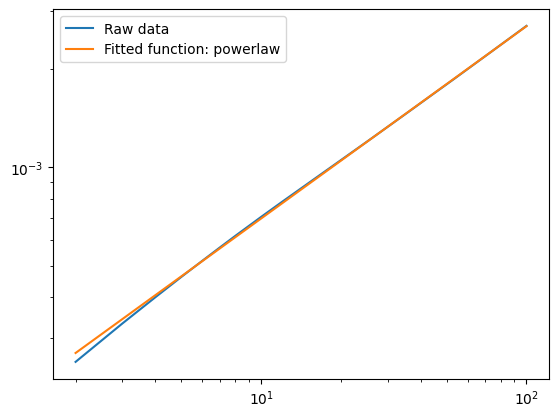

In [44]:
# Retrieve generalized fit object for specific 'STOCK'
tsla_generalized_fit = percentage_returns_fit_objects[('TSLA', 'generalized', 'percentage_returns')]
tsla_generalized_fit.powerlaw.plot_fit()

## 3. Log Returns

In [45]:
# Compute log returns
tsla_log_returns = compute_returns(tsla_raw_df)['log_returns']
msft_log_returns = compute_returns(msft_raw_df)['log_returns']
amzn_log_returns = compute_returns(amzn_raw_df)['log_returns']
nflx_log_returns = compute_returns(nflx_raw_df)['log_returns']
ebay_log_returns = compute_returns(ebay_raw_df)['log_returns']
appl_log_returns = compute_returns(appl_raw_df)['log_returns']

log_returns = {
  'TSLA': tsla_log_returns,
  'MSFT': msft_log_returns,
  'AMZN': amzn_log_returns,
  'NFLX': nflx_log_returns,
  'EBAY': ebay_log_returns,
  'APPL': appl_log_returns
}
# Update the dictionary to only keep the first EVENTS_RANGE items
log_returns = {stock: data.head(EVENTS_RANGE) for stock, data in log_returns.items()}

### Stationarity Test

In [46]:
# ADF test
for stock, data in log_returns.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -313.58
p-value: 0.00,
N: 499994, 
critical values: {'1%': -3.430363078824091, '5%': -2.861545780686305, '10%': -2.5667730768481585}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -350.98
p-value: 0.00,
N: 499995, 
critical values: {'1%': -3.430363078797933, '5%': -2.8615457806747435, '10%': -2.5667730768420047}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -313.60
p-value: 0.00,
N: 499994, 
critical values: {'1%': -3.430363078824091, '5%': -2.861545780686305, '10%': -2.5667730768481585}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -284.79
p-value: 0.00,
N: 499993, 
critical values: {'1%': -3.4303630788502493, '5%': -2.8615457806978664, '10%': -2.566773076854312}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


### 3.1. Log returns ACF

In [47]:
# Linear ACF
log_returns_linear_acf_filename = f"{acf_data_dir}/mo_log_returns_linear_acfs.pkl"
log_returns_linear_acfs = compute_acfs(filename=log_returns_linear_acf_filename, data=log_returns, option='linear')
print(log_returns_linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


In [48]:
# Nonlinear ACF
log_returns_nonlinear_acf_filename = f"{acf_data_dir}/mo_log_returns_nonlinear_acfs.pkl"
log_returns_nonlinear_acfs = compute_acfs(filename=log_returns_nonlinear_acf_filename, data=log_returns, option='nonlinear')
print(log_returns_nonlinear_acfs.keys())

/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multipl

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


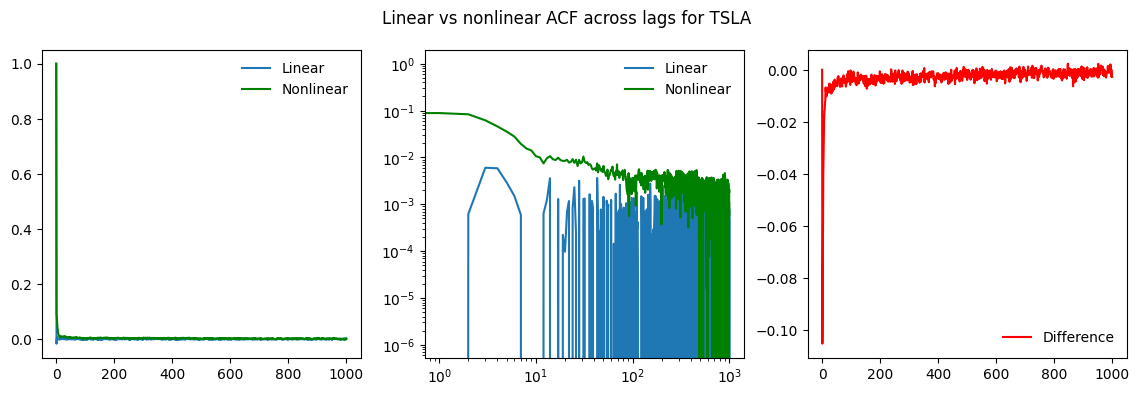

TSLA Max difference: 0.0023154275399599133


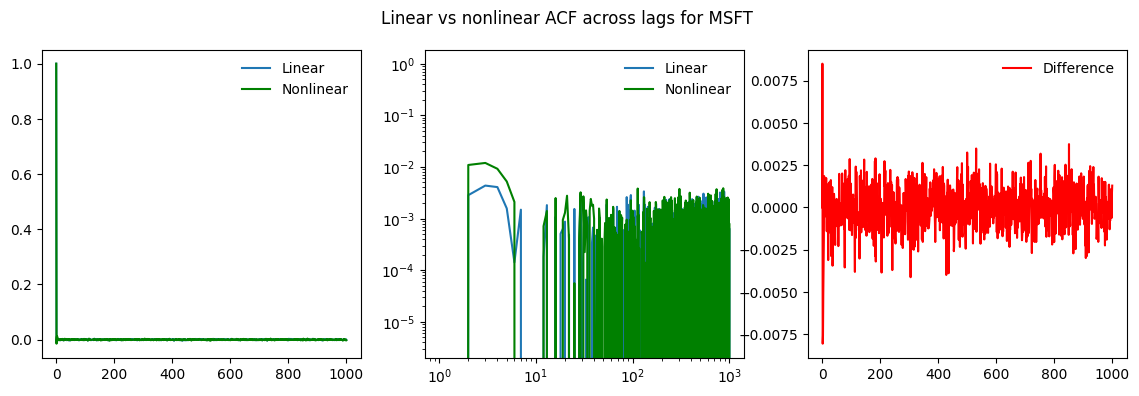

MSFT Max difference: 0.00849494056923164


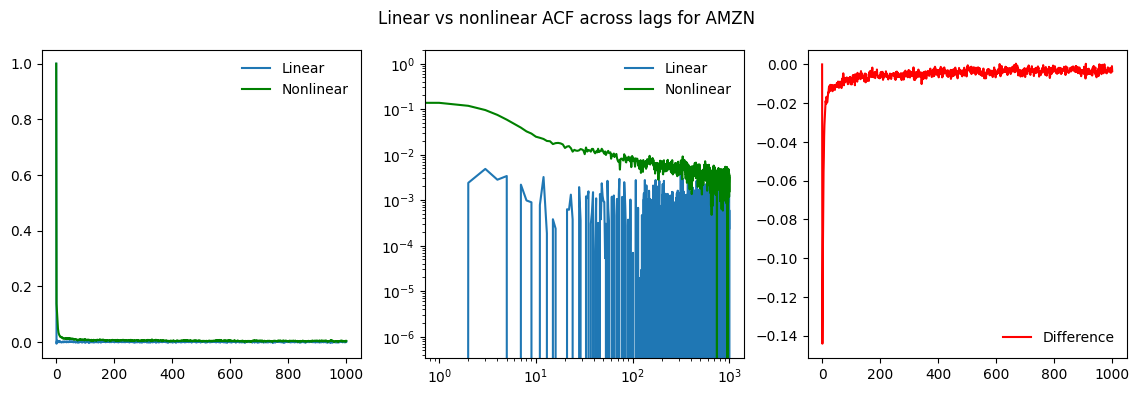

AMZN Max difference: 0.00037957893100317775


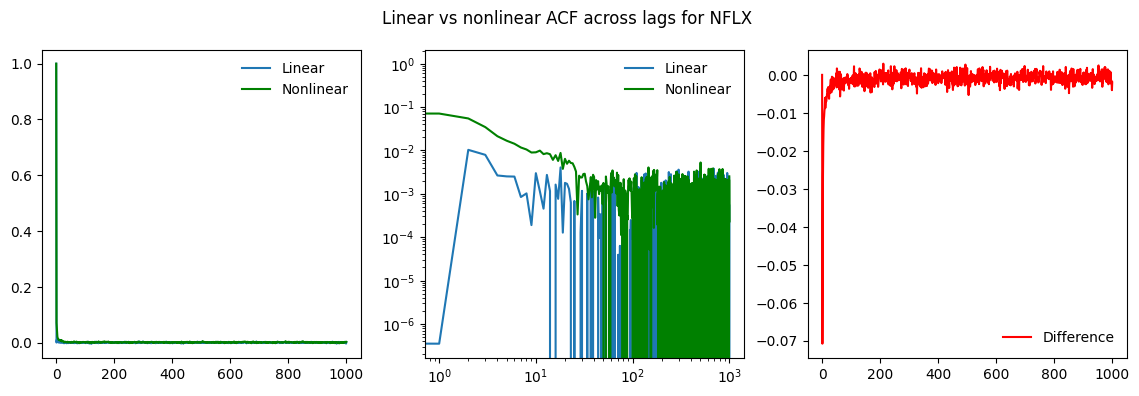

NFLX Max difference: 0.00294599452173891


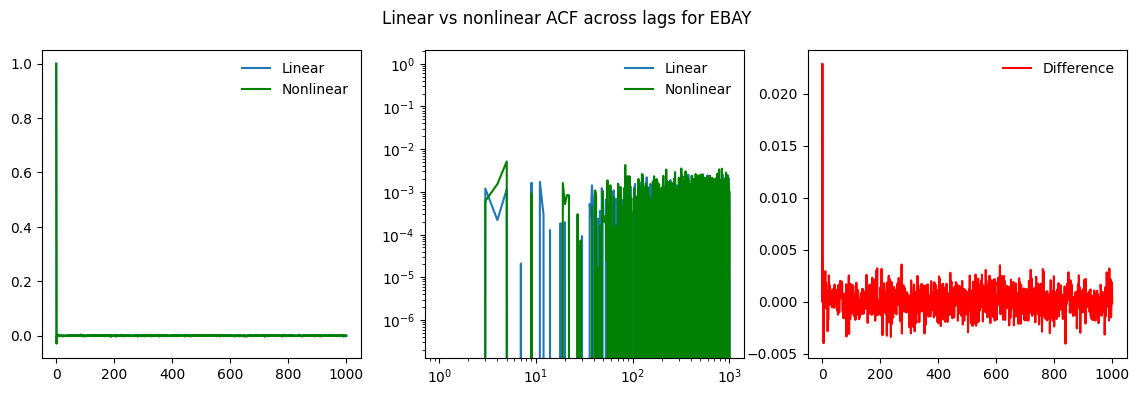

EBAY Max difference: 0.022871123339516075


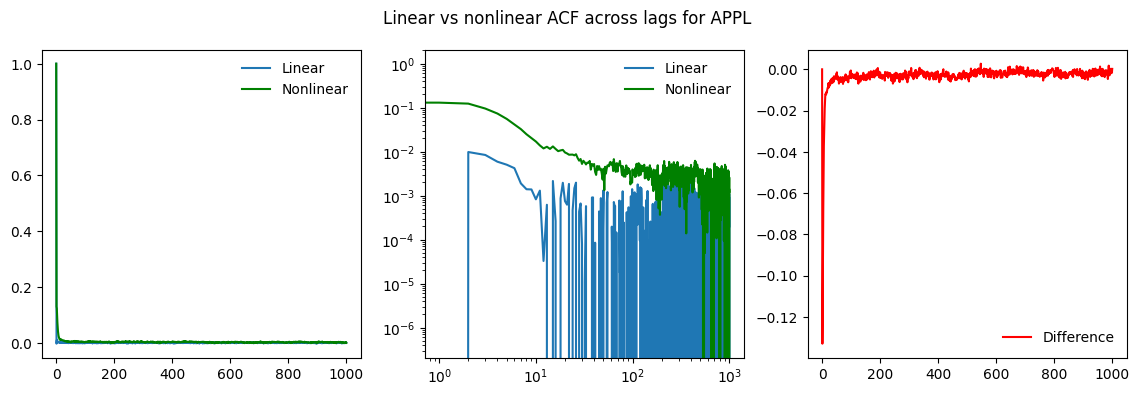

APPL Max difference: 0.002732114449315396


In [49]:
for stock_name in log_returns_linear_acfs.keys():
    plot_acf_difference(stock_name, log_returns_linear_acfs, log_returns_nonlinear_acfs)

### 3.2. Fit power law to log retrurns ACF

In [50]:
# Load the pre-computed ACFs
log_returns_acf_values = {}

for stock, data in log_returns_nonlinear_acfs.items():
    log_returns_acf_values[stock] = construct_xy(data, stock)

In [51]:
# Using log_returns_nonlinear_acfs
log_returns_fit_results_list = []
log_returns_fit_objects = {}  # Dictionary to store fit objects

for stock, data in log_returns_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data, xmin_index=10)
    if fit_dict:
        log_returns_fit_results_list.append(fit_dict)
        log_returns_fit_objects[stock] = fit_obj  # Store the fit object

log_returns_fit_results = pd.DataFrame(log_returns_fit_results_list)
display(log_returns_fit_results.head(10))

cannot unpack non-iterable NoneType object


,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0525368...",5,6.0,0.257028,-13195.658588,123.142922,0.684726,-0.539610,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': -2804.167...",380,381.0,0.483092,-8319.367528,109.931499,-0.001358,-2.743623,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0730200...",7,8.0,0.158954,-13246.386679,31.157839,0.845766,-0.475271,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0436141...",6,7.0,0.290452,-13431.530485,1858.408408,0.375469,-0.707570,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': -122.9332...",592,593.0,0.486553,-5512.092017,129.510374,-0.003442,-2.112884,EBAY
5,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0474148...",7,8.0,0.211268,-13026.149608,562.503020,0.581739,-0.507678,APPL


In [52]:
log_returns_fit_objects.keys()

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])

In [53]:
avg_alpha = log_returns_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

Average Gamma: -1.1811060180307693


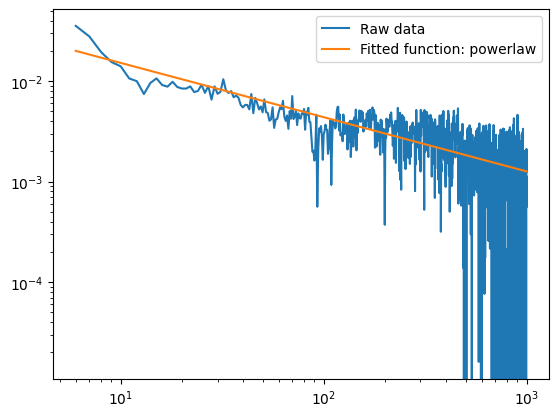

In [54]:
tsla_acf_fit = log_returns_fit_objects['TSLA']
tsla_acf_fit.powerlaw.plot_fit()

### 3.3. Log returns Hurst Exponents

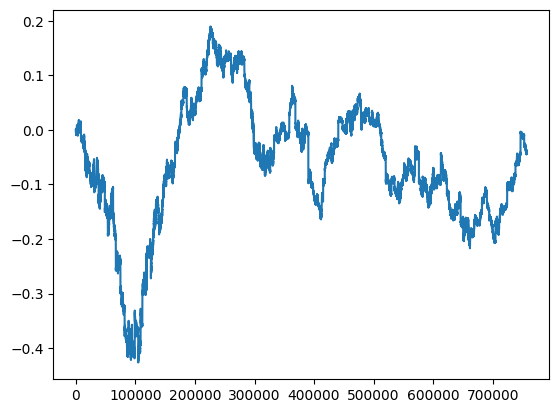

In [55]:
cumsum_log_returns = {
  'TSLA': tsla_log_returns.cumsum(),
  'MSFT': msft_log_returns.cumsum(),
  'AMZN': amzn_log_returns.cumsum(),
  'NFLX': nflx_log_returns.cumsum(),
  'EBAY': ebay_log_returns.cumsum(),
  'APPL': appl_log_returns.cumsum()
}
# Update the dictionary to only keep the first EVENTS_RANGE items
cumsum_log_returns = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_log_returns.items()}
tsla_cumsum_log_returns = compute_returns(tsla_raw_df)['log_returns'].cumsum()
x = list(range(1, len(tsla_cumsum_log_returns)+1))
plt.plot(x, tsla_cumsum_log_returns)
plt.grid(False)
plt.show()

#### Standard Hurst

In [56]:
# Standard Hurst
method = 'standard'
log_returns_fit_results_list = []
log_returns_fit_objects = {}

for stock, data in cumsum_log_returns.items():
    fit_dict, fit = compute_hurst_exponent('log_returns', stock, data, method=method, max_lag=LAG)
    if fit_dict:
        log_returns_fit_results_list.append(fit_dict)
        log_returns_fit_objects[(stock, method, 'log_returns')] = fit

log_returns_std_hurst_fit_results = pd.DataFrame(log_returns_fit_results_list)
display(log_returns_std_hurst_fit_results.head(10))

/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  warnings.warn("Time series contained NaN or Inf values. These values were removed.")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  warnings.warn("Time series contained NaN or Inf values. These values were removed.")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  warnings.warn("Time series contained NaN or Inf values. These values were removed.")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  warnings.warn("Time series contained NaN or Inf values. These values were removed.")


,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0004855...",1,1.0,0.019830,-15495.357940,0.372824,0.999791,0.508129,TSLA,log_returns
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001995...",1,1.0,0.021246,-17093.612910,0.358290,0.999855,0.496982,MSFT,log_returns
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0003397...",1,1.0,0.021246,-16440.859850,0.272144,0.999886,0.505862,AMZN,log_returns
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0003641...",1,1.0,0.021246,-15901.241407,0.479128,0.999783,0.503903,NFLX,log_returns
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0004656...",1,1.0,0.011331,-16457.765306,0.198679,0.999935,0.497648,EBAY,log_returns
5,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0002797...",1,1.0,0.021246,-16548.899404,0.378442,0.999857,0.506910,APPL,log_returns


In [57]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = log_returns_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.5032389000101869


In [58]:
display(log_returns_fit_objects.keys())

dict_keys([('TSLA', 'standard', 'log_returns'), ('MSFT', 'standard', 'log_returns'), ('AMZN', 'standard', 'log_returns'), ('NFLX', 'standard', 'log_returns'), ('EBAY', 'standard', 'log_returns'), ('APPL', 'standard', 'log_returns')])

#### Generalized Hurst

In [59]:
# Generalized Hurst
method = 'generalized'
log_returns_fit_results_list = []
log_returns_fit_objects = {}

for stock, data in cumsum_log_returns.items():
    fit_dict, fit = compute_hurst_exponent('log_returns', stock, data, method=method, max_lag=LAG)
    if fit_dict:
        log_returns_fit_results_list.append(fit_dict)
        log_returns_fit_objects[(stock, method, 'log_returns')] = fit

log_returns_gen_hurst_fit_results = pd.DataFrame(log_returns_fit_results_list)
display(log_returns_gen_hurst_fit_results.head(10))

/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  warnings.warn("Time series contained NaN or Inf values. These values were removed.")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  warnings.warn("Time series contained NaN or Inf values. These values were removed.")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  warnings.warn("Time series contained NaN or Inf values. These values were removed.")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  warnings.warn("Time series contained NaN or Inf values. These values were removed.")


,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001798...",9,2.0,0.011461,-17323.279148,0.323917,0.999962,0.588170,TSLA,log_returns
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 8.3607188...",37,6.0,0.011940,-19366.672951,0.077988,0.999995,0.552863,MSFT,log_returns
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001154...",37,6.0,0.011940,-17645.794589,0.193478,0.999973,0.577631,AMZN,log_returns
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001689...",1,1.0,0.011331,-16866.181043,0.783199,0.999845,0.550622,NFLX,log_returns
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001395...",1,1.0,0.011331,-17572.875714,0.456686,0.999939,0.581732,EBAY,log_returns
5,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001027...",1,1.0,0.011331,-17085.368348,1.094376,0.999777,0.580497,APPL,log_returns


In [60]:
# Generalized Hurst statistic across stocks
min_hurst_gen = log_returns_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = log_returns_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = log_returns_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = log_returns_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.5506222555144853
Max Generalized Hurst: 0.5881704602027613
Average Generalized Hurst: 0.5719193393514709
Standard_dev Generalized Hurst: 0.01602050955605606


In [61]:
display(log_returns_fit_objects.keys())

dict_keys([('TSLA', 'generalized', 'log_returns'), ('MSFT', 'generalized', 'log_returns'), ('AMZN', 'generalized', 'log_returns'), ('NFLX', 'generalized', 'log_returns'), ('EBAY', 'generalized', 'log_returns'), ('APPL', 'generalized', 'log_returns')])

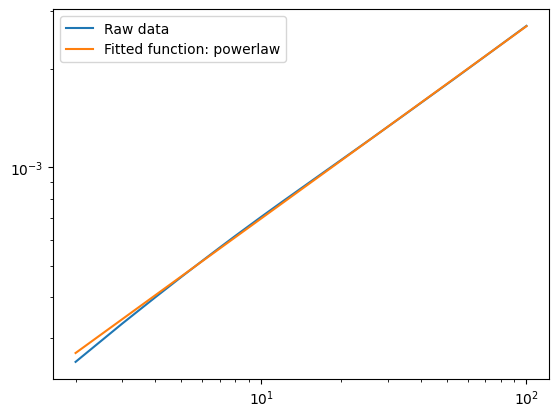

In [62]:
# Retrieve generalized fit object for specific 'STOCK'
tsla_generalized_fit = log_returns_fit_objects[('TSLA', 'generalized', 'log_returns')]
tsla_generalized_fit.powerlaw.plot_fit()

## 4. Return magnitudes

In [76]:
# Return magnitude (volatility)
tsla_volatility = compute_returns(tsla_raw_df)['volatility']
msft_volatility = compute_returns(msft_raw_df)['volatility']
amzn_volatility = compute_returns(amzn_raw_df)['volatility']
nflx_volatility = compute_returns(nflx_raw_df)['volatility']
ebay_volatility = compute_returns(ebay_raw_df)['volatility']
appl_volatility = compute_returns(appl_raw_df)['volatility']

return_magnitudes = {
  'TSLA': tsla_volatility,
  'MSFT': msft_volatility,
  'AMZN': amzn_volatility,
  'NFLX': nflx_volatility,
  'EBAY': ebay_volatility,
  'APPL': appl_volatility
}
# Update the dictionary to only keep the first EVENTS_RANGE items
returns_magnitudes = {stock: data.head(EVENTS_RANGE) for stock, data in return_magnitudes.items()}

### Stationarity Test

In [77]:
# ADF test
for stock, data in return_magnitudes.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -49.89
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -54.43
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -52.60
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -50.20
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.




### 4.1. Return magnitude ACF

In [78]:
# Linear ACF
volatility_linear_acf_filename = f"{acf_data_dir}/mo_volatility_linear_acfs.pkl"
volatility_linear_acfs = compute_acfs(filename=volatility_linear_acf_filename, data=return_magnitudes, option='linear')
display(volatility_linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])

In [79]:
# Nonlinear ACF
volatility_nonlinear_acf_filename = f"{acf_data_dir}/mo_volatility_nonlinear_acfs.pkl"
volatility_nonlinear_acfs = compute_acfs(filename=volatility_nonlinear_acf_filename, data=return_magnitudes, option='nonlinear')
display(volatility_nonlinear_acfs.keys())

/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multipl

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])

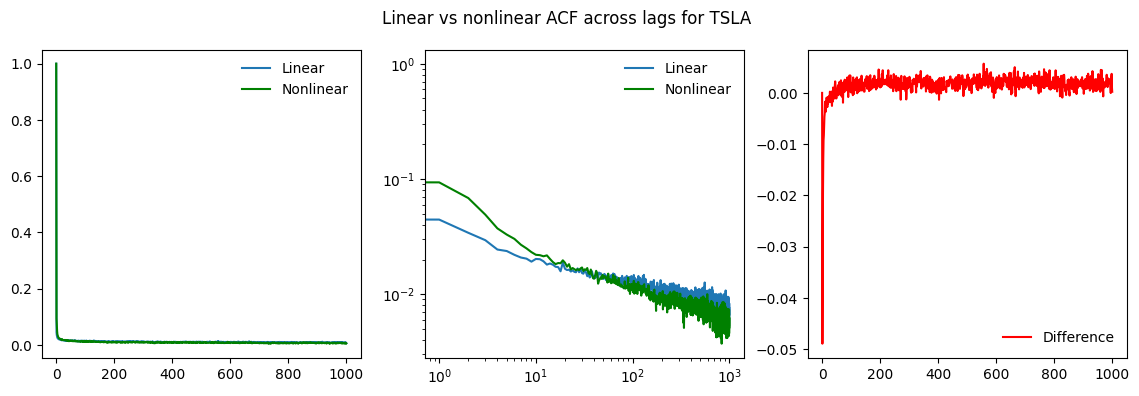

TSLA Max difference: 0.005706750712218543


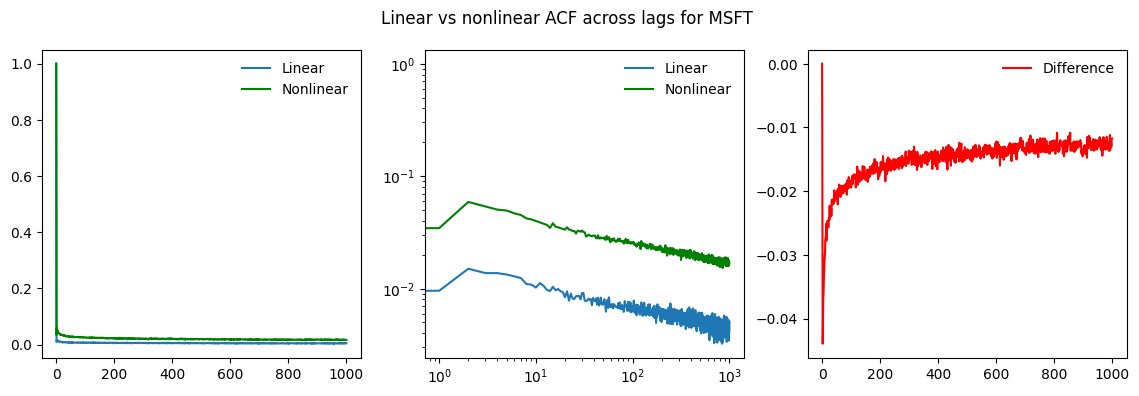

MSFT Max difference: 1.1102230246251565e-16


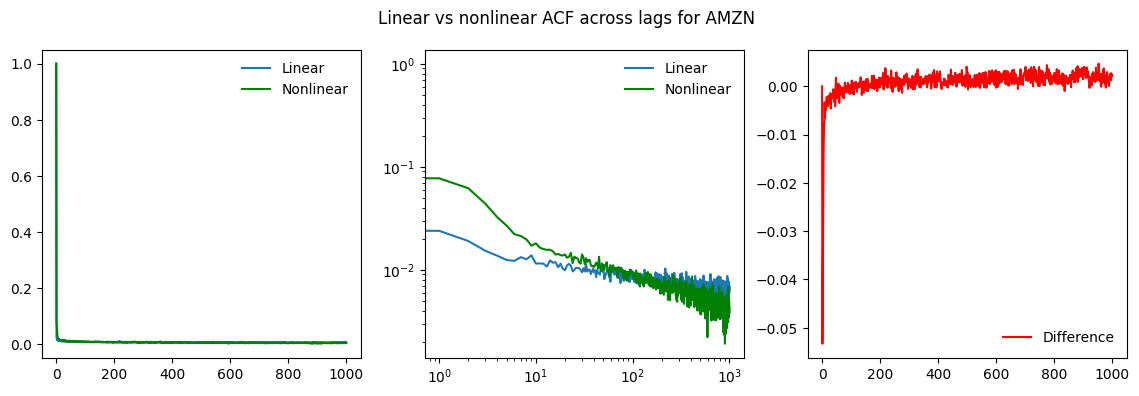

AMZN Max difference: 0.004695065724526252


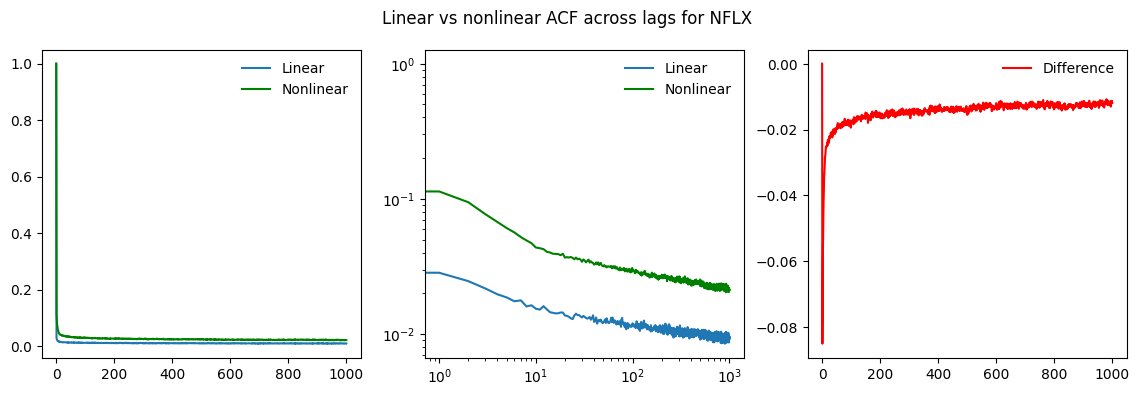

NFLX Max difference: 0.0


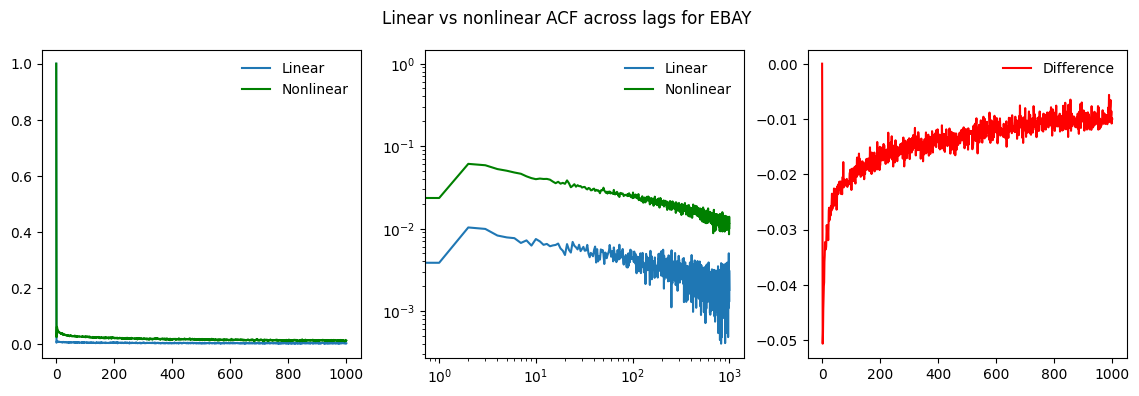

EBAY Max difference: 1.1102230246251565e-16


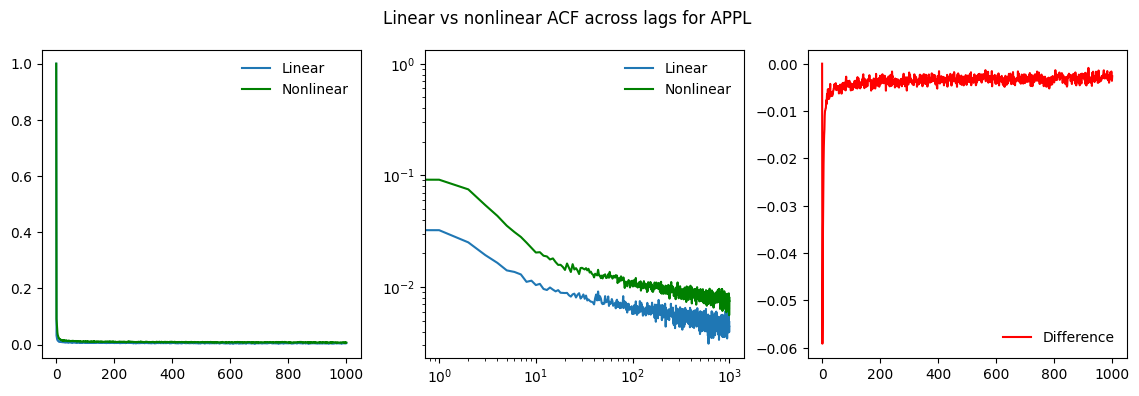

APPL Max difference: 0.0


In [80]:
for stock_name in volatility_linear_acfs.keys():
    plot_acf_difference(stock_name, volatility_linear_acfs, volatility_nonlinear_acfs)

### 4.2. Fit power law to ACF

In [81]:
# Load the pre-computed ACFs
volatility_acf_values = {}

for stock, data in volatility_nonlinear_acfs.items():
    volatility_acf_values[stock] = construct_xy(data, stock)

In [82]:
# Using volatility_nonlinear_acfs
volatility_fit_results_list = []
volatility_fit_objects = {}  # Dictionary to store fit objects

for stock, data in volatility_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data)
    if fit_dict:
        volatility_fit_results_list.append(fit_dict)
        volatility_fit_objects[stock] = fit_obj  # Store the fit object

volatility_acf_fit_results = pd.DataFrame(volatility_fit_results_list)
display(volatility_acf_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0469176...",4,5.0,0.124373,-13816.385521,9.803333,0.901515,-0.299654,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0611851...",3,4.0,0.053106,-14054.993950,3.152123,0.959010,-0.187905,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0441012...",3,4.0,0.128257,-13747.088683,11.866032,0.872422,-0.344441,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0574695...",9,10.0,0.044355,-14430.813882,2.152771,0.961681,-0.144089,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1416698...",171,172.0,0.114458,-11060.519029,7.067004,0.819213,-0.361047,EBAY


In [83]:
avg_alpha = volatility_acf_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

Average Gamma: -0.2550737429939604


In [84]:
volatility_fit_objects.keys()

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])

### 4.3.Volatility Hurst Exponents

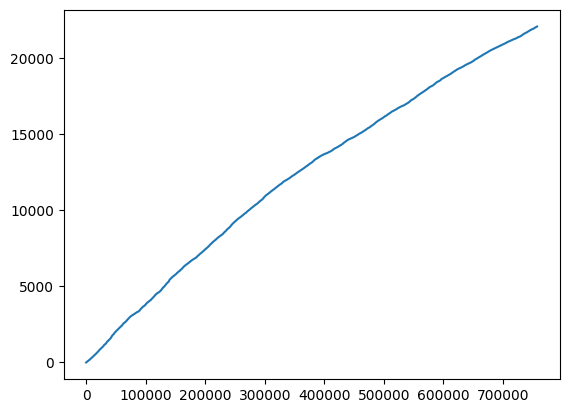

In [88]:
# Return magnitude (volatility)
tsla_volatility = compute_returns(tsla_raw_df)['volatility']
msft_volatility = compute_returns(msft_raw_df)['volatility']
amzn_volatility = compute_returns(amzn_raw_df)['volatility']
nflx_volatility = compute_returns(nflx_raw_df)['volatility']
ebay_volatility = compute_returns(ebay_raw_df)['volatility']
appl_volatility = compute_returns(appl_raw_df)['volatility']

cumsum_return_magnitudes = {
  'TSLA': tsla_volatility.cumsum(),
  'MSFT': msft_volatility.cumsum(),
  'AMZN': amzn_volatility.cumsum(),
  'NFLX': nflx_volatility.cumsum(),
  'EBAY': ebay_volatility.cumsum(),
  'APPL': appl_volatility.cumsum()
}
# Update the dictionary to only keep the first EVENTS_RANGE items
cumsum_return_magnitudes = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_return_magnitudes.items()}
tsla_cumsum_abs_returns = tsla_volatility.cumsum()
x = list(range(1, len(tsla_cumsum_abs_returns)+1))
plt.plot(x, tsla_cumsum_abs_returns)
plt.grid(False)
plt.show()

#### Standard Hurst

In [89]:
# Standard Hurst
method = 'standard'
volatility_fit_results_list = []
volatility_fit_objects = {}

for stock, data in cumsum_return_magnitudes.items():
    fit_dict, fit = compute_hurst_exponent('volatility', stock, data, method=method, max_lag=LAG)
    if fit_dict:
        volatility_fit_results_list.append(fit_dict)
        volatility_fit_objects[(stock, method, 'volatility')] = fit

volatility_std_hurst_fit_results = pd.DataFrame(volatility_fit_results_list)
display(volatility_std_hurst_fit_results.head(10))

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0328730...",1,2.0,0.009915,-4108.888122,2.177744,0.999588,0.822186,TSLA,volatility
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0029916...",1,2.0,0.014164,-7326.785134,2.728687,0.999347,0.806963,MSFT,volatility
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0536906...",63,90.0,0.013975,-2940.726817,1.138371,0.999453,0.837527,AMZN,volatility
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0100428...",1,2.0,0.011331,-5346.063809,2.672239,0.999453,0.845831,NFLX,volatility
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0048788...",1,2.0,0.011331,-7318.545834,2.211088,0.999249,0.730518,EBAY,volatility
5,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0376677...",1,2.0,0.015581,-4563.092515,2.268752,0.998729,0.682113,APPL,volatility


In [90]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = volatility_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.7875230677869006


#### Generalized Hurst

In [91]:
# Generalized Hurst
method = 'generalized'
volatility_fit_results_list = []
volatility_fit_objects = {}

for stock, data in cumsum_return_magnitudes.items():
    fit_dict, fit = compute_hurst_exponent('volatility', stock, data, method=method, max_lag=LAG)
    if fit_dict:
        volatility_fit_results_list.append(fit_dict)
        volatility_fit_objects[(stock, method, 'volatility')] = fit

volatility_gen_hurst_fit_results = pd.DataFrame(volatility_fit_results_list)
display(volatility_gen_hurst_fit_results.head())

/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:152: UserWarning: Hurst exponent may not be in a valid range (0,1).
  warnings.warn("Hurst exponent may not be in a valid range (0,1).")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:152: UserWarning: Hurst exponent may not be in a valid range (0,1).
  warnings.warn("Hurst exponent may not be in a valid range (0,1).")


,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0322025...",1,2.0,0.001416,-13568.168427,0.000913,1.0,1.000067,TSLA,volatility
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0036106...",1,2.0,0.001416,-13863.422664,0.007161,1.0,0.999844,MSFT,volatility
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0512953...",1,2.0,0.001416,-11443.021628,0.002935,1.0,1.000069,AMZN,volatility
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0138521...",1,2.0,0.001416,-12574.752075,0.005988,1.0,0.999779,NFLX,volatility
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0031951...",1,2.0,0.001416,-16450.835160,0.000844,1.0,0.999945,EBAY,volatility


In [92]:
# Generalized Hurst statistic across stocks
min_hurst_gen = volatility_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = volatility_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = volatility_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = volatility_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.9996128564460067
Max Generalized Hurst: 1.0000687142348954
Average Generalized Hurst: 0.9998861593963344
Standard_dev Generalized Hurst: 0.00017748434899418985


In [93]:
print(volatility_fit_objects.keys())

dict_keys([('TSLA', 'generalized', 'volatility'), ('MSFT', 'generalized', 'volatility'), ('AMZN', 'generalized', 'volatility'), ('NFLX', 'generalized', 'volatility'), ('EBAY', 'generalized', 'volatility'), ('APPL', 'generalized', 'volatility')])


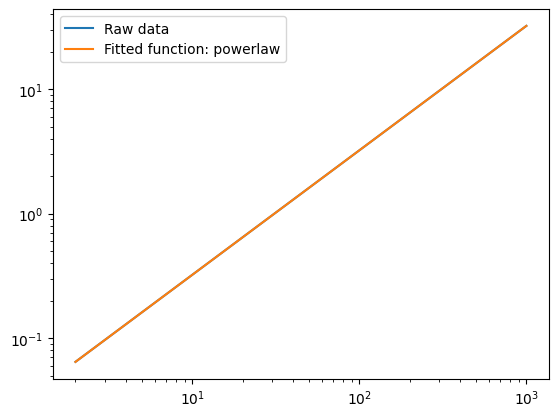

In [94]:
# Retrieve generalized fit object for specific 'STOCK'
tsla_generalized_fit = volatility_fit_objects[('TSLA', 'generalized', 'volatility')]
tsla_generalized_fit.powerlaw.plot_fit()